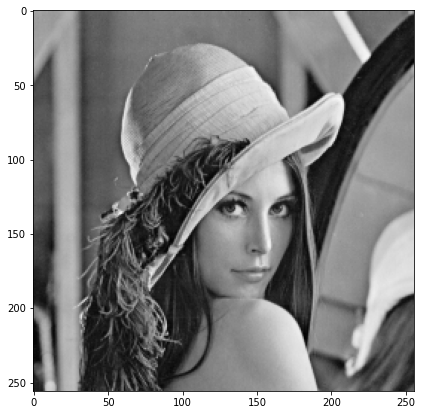

In [1]:
#Importando as bibliotecas
import time
import math
import numpy
import cv2
import matplotlib.pyplot as plt

from numba import njit, jit
from scipy.io import wavfile


from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings

warnings.simplefilter('ignore', category=NumbaWarning)
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

plt.rcParams['figure.figsize'] = (11,7) #Definir o tamanho da imagem que vai aparecer na tela

#Lendo e mostrando a imagem
imagem = cv2.imread('resources/imgs/lena256.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(imagem, cmap = 'gray')
plt.show()

## DCT1D

In [2]:
@jit
def dct1d(x):
    N = len(x)
    k_range = [k for k in range(N)]
    c_k = [math.sqrt(0.5) if k == 0 else 1 for k in k_range]
    factor = [(math.pi*k)/(2*N) for k in k_range]
    result = numpy.zeros(N)
    for k in k_range:
        x_k = 0
        for n in range(N):
            x_k += x[n] * math.cos(2*n*factor[k]+factor[k])
        result[k] = x_k * (math.sqrt(2/N)) * c_k[k]
    return result

## DCT2D

In [3]:
@jit
def dct2d(img):
    result = numpy.array(list(map(dct1d, img))).transpose()
    result = numpy.array(list(map(dct1d, result))).transpose()
    return list(result)

## Aplicando a DCT

In [4]:
img_dct = dct2d(imagem)
dc = img_dct[0][0]
print("Módulo DC =", dc)

Módulo DC = 31883.609375000007


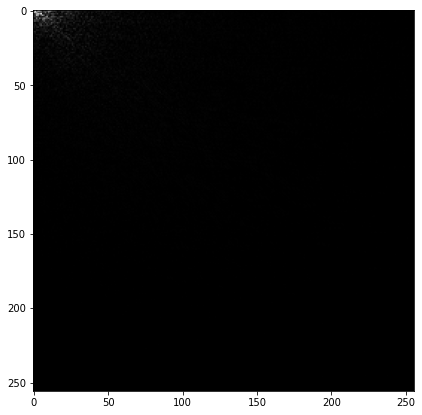

In [5]:
img_dct[0][0] = 0.0
plt.imshow(numpy.abs(img_dct), cmap="gray")
plt.show()

## DCT Normalizada

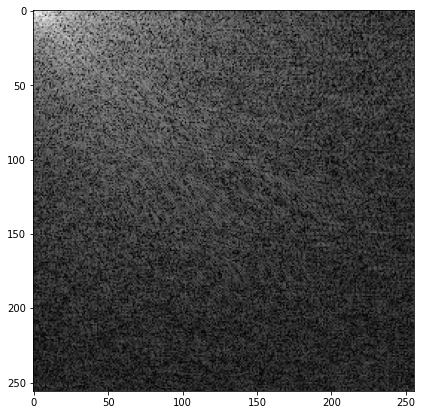

In [6]:
@jit
def dct_norm(dct):
    dct = numpy.copy(dct)
    dct_normalized = numpy.log(numpy.abs(dct) + 1)
    dct_normalized *= (255.0/dct_normalized.max())
    return list(dct_normalized)
plt.imshow(numpy.abs(dct_norm(img_dct)), cmap="gray")
plt.show()

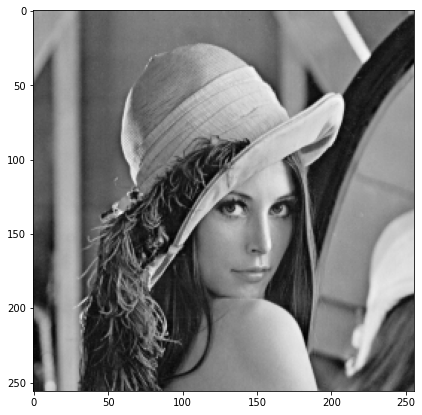

In [7]:
@jit
def idct1d(x: numpy.array) -> numpy.array:
    N = len(x)
    k_range = [k for k in range(N)]
    c_k = [math.sqrt(0.5) if k == 0 else 1 for k in k_range]
    factor = [(math.pi*k)/(2*N) for k in k_range]
    result = numpy.zeros(N)
    for n in range(N):
        x_n = 0
        for k in k_range:
            x_n += c_k[k] * x[k] * math.cos((2*n*factor[k]+factor[k]))
        x_n *= (math.sqrt(2/N))
        result[n] = x_n
    return result
@jit
def idct2d(img):
    result = numpy.array(list(map(idct1d, img))).transpose()
    result = numpy.array(list(map(idct1d, result))).transpose()
    return list(result)

plt.imshow(idct2d(img_dct), cmap="gray")
plt.show()

In [8]:
tempo_dct1 = time.time()
dct2 = dct2d(imagem)
tempo_dct2 = time.time()
tempo_dct = tempo_dct2 - tempo_dct1
print("tempo total dct:", tempo_dct)

tempo_idct1 = time.time()
idct2 = idct2d(dct2)
tempo_idct2 = time.time()
tempo_idct = tempo_idct2 - tempo_idct1
print("tempo total idct:", tempo_idct)

tempo total dct: 0.8352711200714111
tempo total idct: 0.5359992980957031


## Preservando 100 índices AC

100


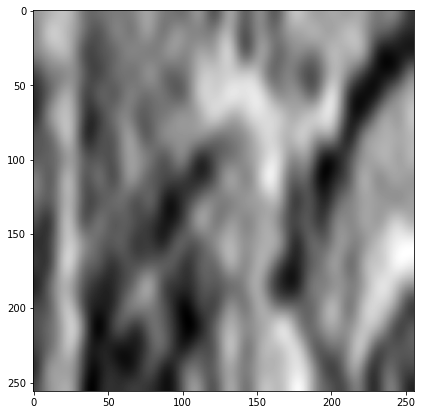

In [9]:
img_dct[0][0] = dc
dct_only11 = numpy.argpartition(numpy.abs(img_dct).flatten(), -100)[-100:]
teste = numpy.vstack(numpy.unravel_index(dct_only11, numpy.copy(dct_norm(img_dct)).shape)).T
new_matrix = numpy.zeros((256,256))
for x in teste:
    new_matrix[x[0]][x[1]] = numpy.copy(img_dct)[x[0]][x[1]]
print(len([x for x in new_matrix.flatten() if x != 0]))
plt.imshow(idct2d(new_matrix), cmap="gray")
plt.show()

In [22]:
@jit
def gain(K):
    degree = 6
    fc = 25000
    g = 0.2
    Y = g / (math.sqrt(1 + math.pow(K/fc, 2 * degree))) + 1 
    result = K * Y
    return result

In [23]:
@jit
def low_pass_filter(K: int) -> float:
    if K < 12520:
        return K
    return 0

In [31]:
def read_audio(filename):
    audio_rate, audio_data = wavfile.read(filename)
    return audio_rate, audio_data

In [25]:
def write_audio(filename, audio_rate, audio_samples):
    audio_tranformado = audio_tranformado.astype("int16")
    wavfile.write(filename, audio_rate, audio_samples)

In [26]:
def plot_audio(data, figsize=[20,6], color="blue", y_label="Amplitude", stroke=0.5, title=""):
    plt.figure('Data', figsize=figsize)
    plt.plot(data, linewidth=stroke,alpha=1,color=color)
    plt.title(title)
    plt.ylabel(y_label)
    plt.show()

In [27]:
@jit
def dct1d_audio_with_gain(x: numpy.array):
    N = len(x)
    k_range = [k for k in range(N)]
    c_k = [math.sqrt(0.5) if k == 0 else 1 for k in k_range]
    factor = [(gain(k)*math.pi)/(2.0*N) for k in k_range]
#     factor = [(math.pi*k)/(2*N) for k in k_range]
    result = numpy.zeros(N)
    for k in k_range:
        x_k = 0
        for n in range(N):
            x_k += x[n] * math.cos(2*n*factor[k]+factor[k])
        result[k] = x_k * (math.sqrt(2/N)) * c_k[k]
    return result

In [28]:
def apply_filter_low_pass(x: numpy.array):
    N = len(x)
    k_range = [k for k in range(N)]
    c_k = [math.sqrt(0.5) if k == 0 else 1 for k in k_range]
    factor = [(low_pass_filter(k)*math.pi)/(2.0*N) for k in k_range]
#     factor = [(math.pi*k)/(2*N) for k in k_range]
    result = numpy.zeros(N)
    for k in k_range:
        x_k = 0
        for n in range(N):
            x_k += x[n] * math.cos(2*n*factor[k]+factor[k])
        result[k] = x_k * (math.sqrt(2/N)) * c_k[k]
    return result

In [41]:
def questao2():
    filename = 'resources/audio/MasEstamosAiPraMais.wav'
    audio_rate, samples_wav = read_audio(filename)

    samples_bass_filter = apply_filter_low_pass(samples_wav)

    signal_amplified = dct1d_audio_with_gain(samples_bass_filter)

    audio = idct1d(signal_amplified)

    write_audio('saida.wave', audio_rate, audio)

    
    

In [42]:
 questao2()